# Part 2: PCA
In class we discussed how PCA can be used as a dimensionality reduction technique as well as latent factor discovery technique. In both cases we used PCA to visualize. Below, we will explore two other applications of PCA, compression and regularization.

I highly recommend that you read the documentation for `np.linalg.svd` before starting.

In [1]:
netid = "xxx"
name = "xxx yyy"
print netid
print name

xxx
xxx yyy


<b>The following lines import the modules we will use.
Do not import any others</b>

In [2]:
import hashlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import misc, ndimage
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

## Compressing an image

We are going to load an image so that we can compress it. This is a way to compress an iamge, but it is not that great, but a lot of other ideas are fundamentally based on this actual principle.

In [3]:
A=misc.imread("./yalelogo.jpeg")

The image starts out as a 3-D numpy array. This is because we effectively have an image for each color channel for R, G, and B. As in class, we will average out these pixel intensities. We will also threshold to obtain a purely black and white image.

In [4]:
A.shape

(78, 179, 4)

In [5]:
Ab=(np.mean(A,2)<100)*1.0

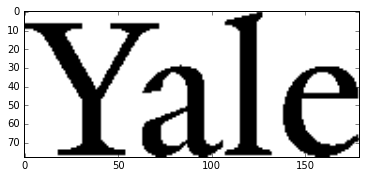

In [6]:
plt.imshow(Ab,cmap=plt.cm.gray)

## Problem A:
The matrix `Ab` is a matrix of 1s and 0s. Plot the singular values of the pictures and compute the best rank $2$ approximation of the matrix and display the image.

In [7]:
u,s,v=np.linalg.svd(Ab,full_matrices=False)

(78, 78) (78,) (78, 179)


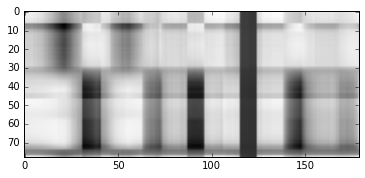

In [8]:
print u.shape,s.shape,v.shape
s[2:]=0
plt.imshow(u[:,range(78)].dot(s.reshape((78,1))*v),cmap=plt.cm.gray)

## Problem B:
In the above we did not remove the means. Now, for each *row* compute the mean of the row and subtract that number from each of the rows. In math, if we let $M$ be our $d_1 \times d_2$ image matrix we want to compute
$$
M - M 1_{d_2} 1_{d_2}^T/d_2
$$
where again $1_{d_2}$ is the all ones *column* vector of length $d_2$. Note, above is slightly different than what happened in class with the TOY example where we removed another mean.

In [9]:
rowmean=np.mean(Ab,axis=1)
Ashifted=Ab-rowmean[:,None]

In [10]:
np.linalg.norm(np.mean(Ashifted,axis=1))

2.8282776493244211e-16

## Problem C:
Now that we have removed the mean. Let's again plot the singular values of the shifted image and recompute the best rank $2$ approximation. Plot the picture by adding back the mean. Do you notice any qualitative differences between the images or the new plots of the singular values?

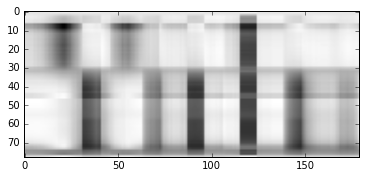

In [12]:
U,S,V=np.linalg.svd(Ashifted)
plt.imshow(((U[:,:2]*S[:2]).dot(V[:2,:])+rowmean[:,None]),cmap=plt.cm.gray)

In [13]:
rowmean.shape

(78,)

Type your brief explanation of the qualitative differences here.

# Visualization of MNIST

## Problem A: Load the MNIST data
Load the MNIST dataset including the images and labels. This will involve you finding the appropriate data again. You can use the previous assignment. Should should have a `labels` array that is `60000x1` and an `mnist` 2-D array that is `60000x(28*28)`

In [19]:
import numpy as np

In [20]:
import gzip
with gzip.open('train-images-idx3-ubyte.gz', 'rb') as f:
    train_images = f.read()

with gzip.open('train-labels-idx1-ubyte.gz','rb') as f:
    train_labels = f.read()
    

MANY STUDENTS did not follow the instructions above and instead created the `mnist` array as a 3-D array.

In [21]:
labels=np.array(bytearray(train_labels[8:]))
mnist=np.array(bytearray(train_images[16:]))
mnist=mnist.reshape(60000,28*28)

## Problem B: Separate the data into 0s and 8s
Now, we will separate the data into $0$ and $8$ values. You should be left with $11774$ images.

In [22]:
I=np.logical_or(labels==0,labels==8)

In [23]:
## you need to find an appropriate choice for I to subselect the appropriate examples
mnist = mnist[I,:]

## Problem C: Compute the average image.
Plot a picture of the average image. That is, compute the mean over all images, and then use `plt.imshow`

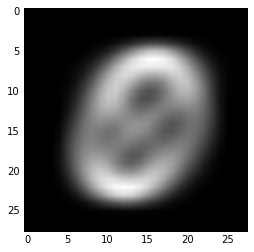

In [24]:
mu=np.mean(mnist,axis=0)

plt.imshow(mu.reshape(28,28),cmap=plt.cm.gray)

## Problem D: Subtract the average image from all of the examples
Use broadcasting to subtract the average image from all of the examples. Same the average image as `mu` and save the new matrix as `mnist_centered`

In [25]:
mnist_centered=mnist-mu

In [26]:
assert np.all(np.isclose(np.sum(mnist_centered,axis=0),0))

## Problem E: Perform pca and visualize the points on the 2-D V-space (head-tilt space)
Plot the points on the 2-D V-space found by projecting your data onto the top two principal components

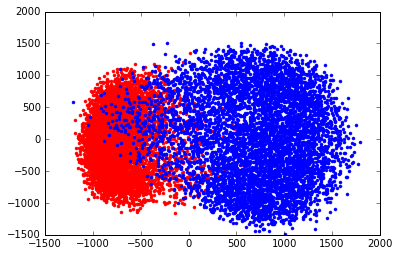

In [27]:
U,S,V=np.linalg.svd(mnist_centered,full_matrices=0)

lowd=mnist_centered.dot(V[:2,:].T)

plt.plot(lowd[labels[I]==8,0],lowd[labels[I]==8,1],'r.')
plt.plot(lowd[labels[I]==0,0],lowd[labels[I]==0,1],'.')

We see the the zeros and eights are separated pretty cleanly. We will explore this a bit more with clustering.

# Linear Regression with PCA.

A common technique in practice is to actually use PCA to reduce the computational complexity of the linear regression problem as well as improve the statistical performance. The method couples the idea of dimensionality reduction and regularization. Let's generate a dataset


In [34]:
np.random.seed(int((hashlib.md5('snn7')).hexdigest(),16) % 200000)
n=1000
d=700
ustar=np.random.normal(0,1,(1,d))
A=np.random.normal(0,1,(n,1)).dot(ustar) + np.random.normal(0,.1,(n,d))
xstar=ustar.T
b=A.dot(xstar)+np.random.normal(0,1,(n,1))

Atest=np.random.normal(0,1,(n,1)).dot(ustar) + np.random.normal(0,.1,(n,d))
btest=Atest.dot(xstar)+np.random.normal(0,1,(n,1))

In class we saw how to project the data down to a $2$-dimensional space. Now we want to see how to do that more generally. In order to do so we provide some extra background.

## SVD Expansion
Recall that the SVD of a matrix $M \in \mathbb{R}^{d_1 \times d_2}$ is
$$
M = U S V^T
$$
where $U$ and $V$ are orthogonal matrices and $S$ is a diagonal matrix. The columns of $U$ are denoted the left singular vectors and the columns of $V$ are denoted that right singular vectors. Let $u_i = U[:,i]$ and $v_i = V[:,i]$. The elements $S[i,i]$ are the singular values of the matrix $M$. Let's let $R = S V^T$ (We are using $R$ for right). Then,
$$
M[:,i] = \sum_{j=1}^{d_1} u_j R[j,i]
$$
In words, the $i^{th}$ column of $M$ is some linear combination of the orthogonal vectors $u_j$. Specifically, they are weighted by $R[j,i]$. Thus, $R[j,i]$ is denoted as the coordinate of column $i$ with respect to $u_j$. Furthermore, because the $u_j$ are orthogonal we can think of the coordinates as belonging to an orthogonal system. The use of this is that we can plot, for example, $R[1,:]$ on the $y$-axis and $R[0,:]$ on the $x$-axis as we did in class.
### How do we find $R$?
In order to find $R$ we can apply the orthogonality of $U$. From above, $M = U R$. Recall that $U^T U = I$. Therefore,
$$
R = U^T M
$$
From that, we can simply extract the different rows of $R$ to obtain the coordinates for each of the different singular vectors $u_j$. Now, since we sorted the diagonal entries of $S$ in decreasing order, the rows capture the information of the matrix $M$ in decreasing order as well.

*Everything we just did with respect to columns carries over with the rows as well*

## Where does linear regression fit?

In linear regressin we have a matrix $A \in \mathbb{R}^{n \times d}$ where we take $n$ to be the number of examples and $d$ is the number of features that each example has. We also have an outcomes $b \in \mathbb{R}^n$. The common way of solving linear regression that we have focused on is ordinary least squares (OLS) where we solve
$$
\hat{x} \in \arg \min_{x} \|A x -b \|_2^2
$$
Some times, the matrix $A$ might be well approximated by some low-rank matrix.

# Problem D:
Find the rank $2$ matrix $\hat{A}_2$ such that
$$
\|\hat{A}_2 - A\|_F^2 = \sum_{i,j} (\hat{A}[i,j] - A[i,j])^2
$$
is minimized

In [35]:
u,s,v=np.linalg.svd(A,full_matrices=False)
print u.shape,s.shape,v.shape
s[2:]=0
Ahat_2 = u[:,range(700)].dot(s.reshape((700,1))*v)

(1000, 700) (700,) (700, 700)


# Problem E:
Now more generally write a python function that computes the best rank $r$ matrix $\hat{A}_r$ such that
$$
\|\hat{A}_r - A\|_F^2 = \sum_{i,j} (\hat{A}[i,j] - A[i,j])^2
$$
is minimized over all rank $r$ matrices.

In [36]:
def bestrankr(A,r):
    u,s,v=np.linalg.svd(A,full_matrices=False)
    s[r:]=0
    return u.dot(s.reshape((len(s),1))*v)
#    return np.zeros((A.shape[0],A.shape[1]))

In [37]:
np.linalg.norm(Ahat_2-bestrankr(A,2))

0.0

Checking above to make sure that `Ahat_2` and `bestrankr(A,2)` is the same

# Problem F:
We want to find a closed form solution of 
$$
x_{k} \in \arg \min_x \|\hat{A}_k x - b\|_2^2
$$
In this case you will not be able to use `np.linalg.solve` because you will get a matrix is singular warning. Instead, use the singular value decomposition and *pretend* that $0/0=0$. As a hint, recall that the optimality conditions state
$$
\hat{A}_k^T \hat{A}_k x_k = \hat{A}_k^T b
$$
We can't invert the matrix on the left. However, we can use that fact that if $A = U S V^T$ is the singular value decomposition, then $U^T U = I$. Algorithmically, gradient descent will still work in this setting.

Write your solution with respect to the matrices $U$, $S$, and $V$. Also write a function to compute the solution.

We will build off the optimality conditions and recall that $\hat{A}_k = U_k S_k V_k^T$. Remember that $V_k^T V_k = I$ Then,
$$
V_k S_k U_k^T U_k S_k V_k^T x_k = V_k S_k U_k^T b
$$
So then
$$
V_k S_k^2 V_k^T x_k = V_k S_k U_k^T b
$$

Proceeding
$$
V_k^T x_k = S_k^{-1} U_k^T b
$$
The above equation suggests that the solution is $x_k = V_k S_k^{-1} U_k^T b$

Indeed, if we plug in $x_k$ into the above optimality conditions we can check that indeed the above is a solution, even though technically we cannot use `np.linalg.solve` to compute the solution because $\hat{A}_k^T \hat{A}$ is not invertible.

In [38]:
def computerankleastsquares(A,b,k):
    u,s,vt=np.linalg.svd(A,full_matrices=False)
    v=vt.T
    return (v[:,:k]*(1./s[:k])).dot(u[:,:k].T).dot(b)


In [39]:
def computerankleastsquareshack(A,b,k):
    Ar=bestrankr(A,k)
    u,s,v=np.linalg.svd(A,full_matrices=False)
    v=v[range(k),:]
    return v.T.dot(v.dot(np.linalg.solve(Ar.T.dot(Ar)+0.00000000001*np.identity(Ar.shape[1]),Ar.T.dot(b))))
    #return np.zeros((A.shape[1],1))

In [47]:
xhat=np.linalg.solve(A.T.dot(A),A.T.dot(b))
xcheck=computerankleastsquares(A,b,2)
np.linalg.norm(Atest.dot(xhat)-btest)**2/Atest.shape[0], np.linalg.norm(Atest.dot(xcheck)-btest)**2/Atest.shape[0]

(3.6120582058889243, 0.9567717858862117)

Notice in the above that the regular solution to least squares has a much larger error than the rank $2$ solution to least squares on the test data. Of course, on the training data, the full solution to least squares is larger.

In [48]:
xhat=np.linalg.solve(A.T.dot(A),A.T.dot(b))
xcheck=computerankleastsquares(A,b,2)
np.linalg.norm(A.dot(xhat)-b)**2/A.shape[0], np.linalg.norm(A.dot(xcheck)-b)**2/A.shape[0]

(0.29729491612376557, 0.97504140577059284)

# Problem G:
Now, using cross-validation from the part 1, compute the optimal $k$ for minimizing the error. You cannot use the test set.

In [49]:
def crossvalidation(A,b,I,k,kstart=1):
    #A is the feature matrix
    #b is the outcomes vector
    #I is the numpy matrix where I[k] is a length n row of boolean values indexing the examples in partition k
    # this cross validation code will loop from 1 to rank k
    K=I.shape[0]
    erroratk=np.zeros((K,k-kstart+1))
    for j in range(K):
        Afold=A[np.logical_not(I[j])]
        bfold=b[np.logical_not(I[j])]
        u,s,v=np.linalg.svd(Afold)
        Atest=A[I[j],:]
        btest=b[I[j]]
        rankindex=0
        for checkrank in range(kstart,k+1):
            xhat=v.T[:,range(checkrank)].dot(1./s[range(checkrank)].reshape((checkrank,1))*u[:,range(checkrank)].T.dot(bfold))
            erroratk[j,rankindex]=np.sum((Atest.dot(xhat)-btest)**2)/np.sum(I[j])
            rankindex+=1
    return erroratk

In [50]:
Ifolds=(np.zeros((10,n))==1)
##put your Ifolds code generation here
for j in range(10):
    Ifolds[j][range(100*j,100*(j+1))]=True

In [51]:
VVVVV=np.mean(crossvalidation(A,b,Ifolds,500,kstart=1),axis=0)

In [56]:
min_k = range(1,501)[np.argmin(VVVVV)]

In [57]:
min_k

1

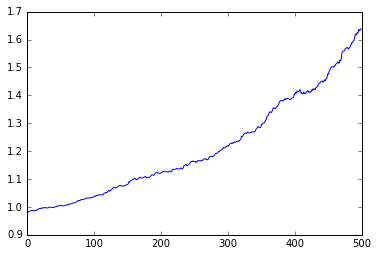

In [52]:
plt.plot(VVVVV)

We see that the best $k$ by cross-validation is in fact $k=1$!

Let
$$
V_k = \left ( v_1 v_2 ... v_k \right )
$$
be the $d \times k$ matrix of just the first $k$ columns of the matrix $V$ of right singular vectors of the matrix $A$. Again, please read the numpy documentation for `np.linalg.svd` because of how it outputs the matrix $V$.

Let's generate a new test set.

In [59]:
Btest=np.random.normal(0,1,(n,1)).dot(ustar)
Atest=Btest + np.random.normal(0,.1,(n,d))
btest=Atest.dot(xstar)+np.random.normal(0,1,(n,1))

Now on the test set, compare the test error between  $\|A_{test} \hat{x} - b_{test}\|_2^2$, $\|A_{test} x_k - b_{test}\|_2^2$, $\|A_{test} V_k V_k^T \hat{x} - b_{test}\|_2^2$, and $\|A_{test} V_k V_k^T x_k - b_{test}\|_2^2$. Can you explain the differences?

In [61]:
xhat=np.linalg.solve(A.T.dot(A),A.T.dot(b))
x_k = computerankleastsquares(A,b,1)
u,s,v=np.linalg.svd(A,full_matrices=False)
v=v.T
vk=v[:,:1]

In [65]:
print(np.linalg.norm(Atest.dot(xhat)-btest)**2/Atest.shape[0],
      np.linalg.norm(Atest.dot(x_k)-btest)**2/Atest.shape[0],
    np.linalg.norm(Atest.dot(vk.dot(vk.T.dot(xhat)))-btest)**2/Atest.shape[0],
      np.linalg.norm(Atest.dot(vk.dot(vk.T.dot(x_k)))-btest)**2/Atest.shape[0])

(3.3692644032052765, 1.0589685551657773, 1.0589685551656702, 1.0589685551656882)


The first one is the largest due to over-fitting. The next three are all the same because the low-rank solution for least squares can actually be viewed as a projection of the original solution onto the first $k$ right singular vectors of the matrix $A$

# Problem H (Bonus):
Can you find any connections between ridge regression from the previous problem and low-rank regularized linear regression?

Come to office hours to discuss this.